<a href="https://colab.research.google.com/github/Geetika-L/Econ_472/blob/dev/Econ_472_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
!pip install scikit-optimize --user
!pip install scikit-learn==1.2.1 --user
!pip install numpy==1.22.4 --user

In [3]:
data_v1 = pd.read_csv('fred_data_trans_v1.csv')

In [4]:
current = pd.read_csv('current.csv')

In [5]:
## Replace CPI transformation by CPI_yoy growth
CPI = current['CPIAUCSL'][1:]
CPI_yoy = CPI.pct_change(periods=12)*100
data_v1['CPIAUCSL'] = CPI_yoy[12:].reset_index(drop=True)

In [6]:
percent_missing = list(data_v1.isna().sum()/(data_v1.shape[0]))
missing_value_df = pd.DataFrame({'column_name': data_v1.columns,
                                 'percent_missing': percent_missing})

In [7]:
## Prportion of columns that have high NAs
missing_value_df_01 = missing_value_df.loc[missing_value_df['percent_missing']>0.1]
## Higher than 0.1 (ACOGNO:New Orders for Consumer Goods, ANDENOx: New Orders for Nondefense Capital Goods,  TWEXAFEGSMTHx: Trade weighted us dollar index)

In [8]:
## Remove high proportion of NAs
col_to_rem_NA = missing_value_df_01['column_name'].tolist()
data_v1.drop(col_to_rem_NA, axis =1, inplace= True)


In [9]:
## Remove CPI columns except CPI: All items
cpis_except_all_items = ['CPIAPPSL', 'CPITRNSL', 'CPIMEDSL', 'CUSR0000SAC', 'CUSR0000SAD', 'CUSR0000SAS', 'CPIULFSL', 'CUSR0000SA0L2', 'CUSR0000SA0L5']
data_v1.drop(cpis_except_all_items, axis =1, inplace= True)


In [10]:
## Remove the date column
data_v1.drop('date', axis =1, inplace= True)


In [11]:
## Creating lag and AR variables
def series_to_supervised(data, n_in=1):
 """
 Frame a time series as a supervised learning dataset.
 Arguments:
 data: Sequence of observations as a list or NumPy array.
 n_in: Number of lag observations as input (X).
 n_out: Number of observations as output (y).
 dropnan: Boolean whether or not to drop rows with NaN values.
 Returns:
 Pandas DataFrame of series framed for supervised learning.
 """

 n_vars = 1 if type(data.values) is list else data.shape[1]
 colnames = list(data.columns)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
   cols.append(data.shift(i))
   names += [j+"_{0}".format(i) for j in colnames]
 cols.append(data['CPIAUCSL'])
 names += ['CPIAUCSL_0']
 
 # put it all together
 agg = pd.concat(cols, axis=1)
 agg.columns = names
 return agg
#  # drop rows with NaN values
#  if dropnan:
#  agg.dropna(inplace=True)
#  return agg


In [12]:
data_lagged = series_to_supervised(data_v1,3)

In [13]:
data_lagged_sorted = data_lagged.reindex(sorted(data_lagged.columns), axis=1)

In [14]:
data_lagged_sorted.to_csv('data_lagged_v1.csv')

In [15]:
## Remove first 3 observations (missing lags), and last 12 observations to keep as test set
test_length = 12
startpoint = 3
endpoint = len(data_lagged)
x = endpoint- test_length
data_lagged_train = data_lagged.loc[startpoint:x - 1, :]
data_lagged_test = data_lagged.loc[x:, :]
data_lagged_test_x = data_lagged_test.loc[:, data_lagged_test.columns != 'CPIAUCSL_0']
data_lagged_test_y = data_lagged_test['CPIAUCSL_0']
data_lagged_train_x = data_lagged_train.loc[:, data_lagged_train.columns != 'CPIAUCSL_0']
data_lagged_train_y = data_lagged_train['CPIAUCSL_0']

In [16]:
## Getting mean of training dataset to impute
import numpy as np
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values = np.nan, strategy = 'mean').set_output(transform="pandas")
imp.fit(data_lagged_train_x)

SimpleImputer()

In [17]:
##Impute training data x

data_lagged_train_x_imp = imp.transform(data_lagged_train_x)

In [18]:
data_lagged_train_x_imp.head(5)

,RPI_3,W875RX1_3,DPCERA3M086SBEA_3,CMRMTSPLx_3,RETAILx_3,INDPRO_3,IPFPNSS_3,IPFINAL_3,IPCONGD_3,IPDCONGD_3,...,DNDGRG3M086SBEA_1,DSERRG3M086SBEA_1,CES0600000008_1,CES2000000008_1,CES3000000008_1,UMCSENTx_1,DTCOLNVHFNM_1,DTCTHFNM_1,INVEST_1,VIXCLSx_1
3,0.003194,0.004638,0.002788,0.016956,0.026606,0.025914,0.024097,0.029021,0.031237,0.103831,...,0.001786,-0.001113,-0.000020,0.030131,-0.004684,0.0,0.003472,0.000951,0.003490,19.294122
4,0.001143,0.000917,0.004335,0.014371,0.003696,-0.008936,-0.005683,-0.003441,-0.011454,-0.013854,...,0.004439,0.001450,-0.008949,-0.068074,0.000000,0.0,0.008678,0.005452,0.024136,19.294122
5,0.001909,0.000916,0.014041,-0.028026,-0.001102,-0.009020,-0.003429,-0.001145,0.001151,-0.019966,...,-0.006723,0.000591,0.008949,0.041620,0.000000,-6.7,-0.004827,-0.002067,0.003798,19.294122
6,0.003419,0.003614,0.015355,0.009826,0.025903,-0.007958,0.002289,0.001145,0.006879,-0.001186,...,0.000222,-0.000686,-0.004474,-0.011429,0.000000,0.0,0.005126,0.007420,-0.009981,19.294122
7,0.002401,0.002443,-0.020343,-0.031531,-0.015047,-0.001144,0.005690,0.006866,0.005699,0.009453,...,0.001828,0.000504,0.004454,0.007547,0.000000,0.0,-0.010926,-0.003291,0.032176,19.294122


In [19]:
data_lagged_train_x_imp['CPIAUCSL_1']

3      1.518813
4      1.932367
5      1.825069
6      1.717623
7      1.372213
         ...   
739    5.276105
740    5.205332
741    5.389907
742    6.236941
743    6.828372
Name: CPIAUCSL_1, Length: 741, dtype: float64

In [20]:
data_lagged_train_x_imp.shape

(741, 345)

# Setting up BayesSearchCV

In [21]:
# from sklearn.ensemble import RandomForestRegressor
# from skopt import BayesSearchCV,space

# param_dist = {
#     "max_depth": space.Integer(3, 6),
#     "max_features": space.Integer(40, 120),
#     "min_samples_split": space.Integer(2,5), # from 2 to 10
#     "min_samples_leaf": space.Integer(5,7), # from 1 to 10
#    }

In [22]:
# search_v2 = BayesSearchCV(RandomForestRegressor(n_estimators=150, random_state=153),
#                        param_dist,random_state=153,scoring='neg_mean_squared_error', n_iter=30,verbose=2)

In [23]:
# search_v2.fit(data_lagged_train_x_imp,data_lagged_train_y)

In [24]:
# search_v2.best_params_

In [25]:
# # Trying another search based on previous best params
# param_dist_1 = {
#     "max_depth": space.Integer(5, 10),
#     "max_features": space.Integer(115, 160),
#     "min_samples_split": space.Integer(5,10), 
#     "min_samples_leaf": space.Integer(4,7)
#    }

In [26]:
# search_v3 = BayesSearchCV(RandomForestRegressor(n_estimators=250, random_state=153),
#                        param_dist_1,random_state=153,scoring='neg_mean_squared_error', n_iter=50,verbose=2, cv=5)

# search_v1.fit(data_lagged_train_x_imp,data_lagged_train_y)

In [27]:
# abs(search_v2.best_score_)

In [28]:
# abs(search_v3.best_score_)

In [29]:
# search_v2.best_estimator_

In [30]:
# search_v3.best_estimator_

In [31]:
# Pickle and dump random forests
# from joblib import dump,load
# dump(search_v2.best_estimator_, 'search_v2.joblib')
# dump(search_v3.best_estimator_,'search_v3.joblib')

In [32]:
##Upload rf models to test

In [33]:
## Model v0 and v1 - from first search
from joblib import load
model_v2 = load('search_v2.joblib')
model_v3 = load('search_v3.joblib')

In [34]:
## Extracting the date column for analysis
start_date = pd.to_datetime('01-1960', format='%m-%Y')
end_date = pd.to_datetime('12-2022', format='%m-%Y')
date_list = list(map(lambda x: x.strftime('%m-%Y'), pd.date_range(start_date, end_date, freq="MS")))
date_train = date_list[startpoint:x]
date_test = date_list[x:]

#### Using the same data in the first row for everything in non CPI lags (i.e using december 2021 data for Jan- Dec 2022 preds)

In [35]:
def forecast_ahead_12_fixed_lag_vals(model_fc, test_data_og):
  test_data = test_data_og.copy(deep = True)
  test_data.reset_index(drop=True, inplace = True)
  CPI_lags_cols = ['CPIAUCSL_1','CPIAUCSL_2','CPIAUCSL_3']
  ## Split data in CPI and non CPI
  df_non_CPI = test_data.drop(columns=CPI_lags_cols)
  df_non_CPI_fixed_lags_vals = pd.concat(([df_non_CPI.iloc[[0]]])*12,ignore_index=True)
  df_CPI = test_data[CPI_lags_cols]
  test_data = pd.concat([df_CPI.reset_index(drop=True), df_non_CPI_fixed_lags_vals.reset_index(drop=True)], axis= 1)
  test_data = test_data[test_data_og.columns]

  y_pred_test = []
  for i in range(12):
    y = model_fc.predict(test_data.iloc[[i]])
    y_pred_test.append(y)
    prev_CPI_2 = test_data.loc[i]['CPIAUCSL_2']
    prev_CPI_1 = test_data.loc[i]['CPIAUCSL_1']
    if i < 11:
        test_data.loc[i+1]['CPIAUCSL_1'] = y
        test_data.loc[i+1]['CPIAUCSL_2'] = prev_CPI_1
        test_data.loc[i+1]['CPIAUCSL_3'] = prev_CPI_2
  ##flatten y_pred_test
  y_pred_test = np.ravel(y_pred_test)

  return y_pred_test, test_data

In [38]:
## Creating a scoring function
def mse_horizons(true, predicted):
  mse_vals=[]
  if len(true) == len(predicted):
    array_abs_diff = (true-predicted)**2
    for i in range(len(true)):
      mse_vals.append(np.mean(array_abs_diff[:i+1]))
  return mse_vals

In [39]:
## Creating the predictions and updated test dataset for both models v0 and v1
y_pred_test_model_v2, test_data_model_v2 = forecast_ahead_12_fixed_lag_vals(model_v2,data_lagged_test_x_imp)
y_pred_test_model_v3, test_data_model_v3 = forecast_ahead_12_fixed_lag_vals(model_v3,data_lagged_test_x_imp)

In [40]:
mse_model_v2 = mse_horizons(data_lagged_test_y,y_pred_test_model_v2)
mse_model_v3 = mse_horizons(data_lagged_test_y,y_pred_test_model_v3)

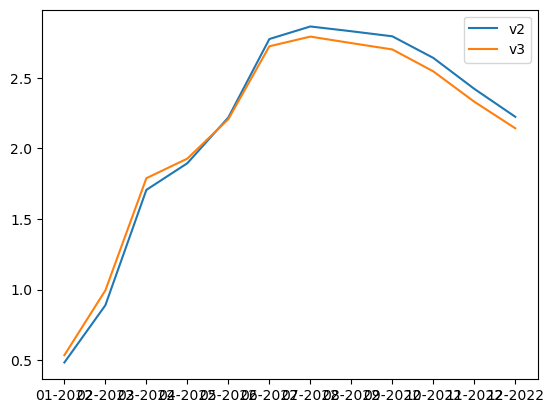

In [42]:
import matplotlib.pyplot as plt
plt.plot(date_test,mse_model_v2, label= 'v2')
plt.plot(date_test,mse_model_v3, label = 'v3')
plt.xticks(date_test)
plt.legend()
plt.show()

##Using model v3 as from now on for rest of analysis